# Aids N' Such
##### Sean Wade

In [18]:
from __future__ import division, print_function
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

## Problem 1

HIV is unique because it specifically targets T cells, that is it targets what is supposed to kill it. AIDS comes from the loss of T cells and is not a virus.

## Problem 2

There is no cure for aids, but there are medicines to help immune system and hurt disease.

## Problem 3

In [3]:
def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    
    def initialize_all(y0, t0, t, n):
        """ An initialization routine for the different ODE solving
        methods in the lab. This initializes Y, T, and h. """
        if isinstance(y0, np.ndarray):
            Y = np.empty((n, y0.size)).squeeze()
        else:
            Y = np.empty(n)

        Y[0] = y0
        T = np.linspace(t0, t, n)
        h = float(t - t0) / (n - 1)
        return Y, T, h
    
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in xrange(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

In [7]:
# Init Variables
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 1000
t0 = 0

#Initialize global variables
state = np.zeros((n,2))
state0 = np.array([T0, V0])
costate = np.zeros((n,2))
costate0 = np.zeros(2)
u=np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9

In [8]:
def state_equations(t,y,i):
    ''' Defines the state equations.
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the T cell concentration and the Virus concentration at time t
    i : int
    index for the global variable u.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the T cell concentration and the virus ←-
    concentration at time t
    '''
    T, V = y[0], y[1]
    dT = s_1 - (s_2*V)/(B_1 + V) - mu*T - k*V*T + u[i,0]*T 
    dV = ((g*V)/(B_2 + V))*(1-u[i,1]) - c*V*T
    return  np.array([dT, dV])

## Problem 4

In [13]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda values at time tf-t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    '''
    # If something is wrong look at i vs -i
    l1, l2 = y[0], y[1]
    l_hat1 = l1*(-mu-k*state[-i,1]+ u[-i,0])- c*l2*state[-i,1]-1
    l_hat2 = -l1*((s_2*B_1)/(B_1+state[-i,1])**2 + k*(state[-i,0])) \
        + l2*((g*B_2*(1-u[-i,1]))/(B_2 + state[-i,1])**2 - c*state[-i,0])
        
    return np.array([l_hat1, l_hat2])

## Problem 5

In [24]:
epsilon = 0.001
test = epsilon + 1
time = np.linspace(0,t_f,n)
a1_vals = np.linspace(a_1, a_1, n)
b1_vals = np.linspace(b_1, b_1, n)
a2_vals = np.linspace(a_2, a_2, n)
b2_vals = np.linspace(b_2, b_2, n)

while(test > epsilon):
    oldu = u.copy();
    
    #solve the state eq forward
    state = RK4(state_equations, np.array([T0,V0]), t0, t_f, n)
    T,V = state[:,0], state[:,1]
    
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat, np.array([0,0]), t0, t_f, n)[::-1]
    l1, l2 = costate[:,0], costate[:,1]
    
    #solve for u1 and u2
    u_star1 = -1/(2*A_1) * np.multiply(l1,T)
    u1 = np.minimum(np.maximum(a1_vals, u_star1), b1_vals)
    
    u_star2 = 1/(2*A_2)* np.multiply(l2, g*V/(B_2 + V))
    u2 = np.minimum(np.maximum(a2_vals,u_star2), b2_vals)
     
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    #test for convergence
    test = abs(oldu - u).sum()

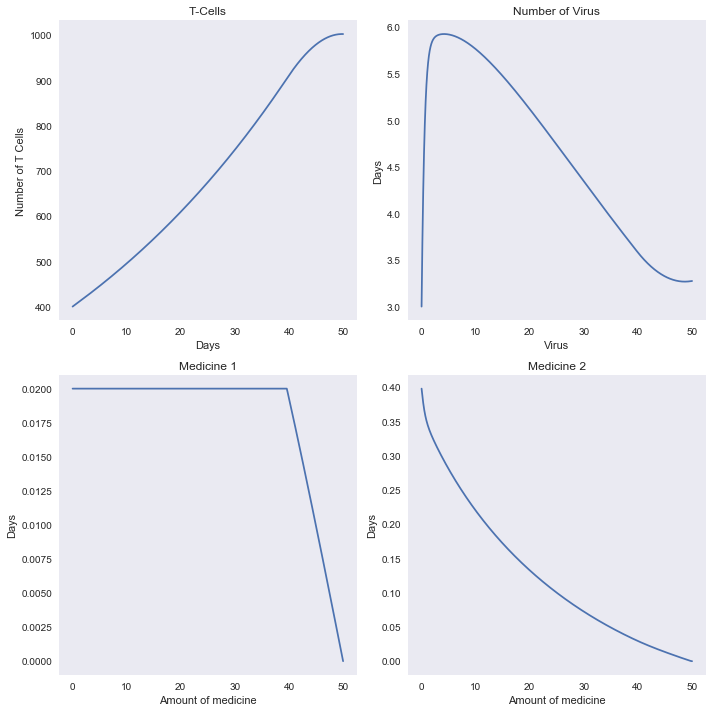

In [25]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.plot(time, T)
plt.title("T-Cells")
plt.xlabel('Days')
plt.ylabel('Number of T Cells')

plt.subplot(222)
plt.plot(time, V)
plt.title('Number of Virus')
plt.xlabel('Virus')
plt.ylabel('Days')

plt.subplot(223)
plt.plot(time, u1)
plt.title('Medicine 1')
plt.xlabel('Amount of medicine')
plt.ylabel('Days')

plt.subplot(224)
plt.plot(time, u2)
plt.title('Medicine 2')
plt.xlabel('Amount of Medicine')
plt.ylabel('Days')

plt.tight_layout()
plt.show()